In [1]:
%%time
!pip install -q --upgrade pip fastai

CPU times: user 23.4 ms, sys: 5.72 ms, total: 29.1 ms
Wall time: 1.8 s


In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai.vision import *
from fastai.callbacks import CSVLogger

In [4]:
NUMBER_OF_SAMPLES = 50_000
SIZE = 224 // 8 
MAGNIFICATION = 8
INSETS = 2
THRESHOLD = 0.8

NUMBER_OF_SAMPLES * SIZE * SIZE

39200000

# Creating test data

In [5]:
from PIL import ImageDraw as PILImageDraw
from PIL import Image as PILImage

def create_data():
    return np.random.standard_normal(
        size=(NUMBER_OF_SAMPLES, SIZE, SIZE)) > THRESHOLD

def get_label(data):
    return float(np.sum(data, axis=(0,1)))

def render_image(data):
    img = PILImage.new('RGB', (SIZE*MAGNIFICATION, SIZE*MAGNIFICATION), color = (255,255, 255))
    draw = PILImageDraw.Draw(img)

    for (row_index, row) in enumerate(data):
        for (col_index, value) in enumerate(row):
            x0, y0 = row_index*MAGNIFICATION+INSETS, col_index*MAGNIFICATION+INSETS
            x1, y1 = ((row_index+1)*MAGNIFICATION-INSETS)+1, \
                     ((col_index+1)*MAGNIFICATION-INSETS)+1

            if value: 
                draw.rectangle([(x0, y0), (x1, y1)], fill=(255, 153, 0))  
                
    return Image(pil2tensor(img, np.float32).div(255))

class MyImageItemList(ImageList):
    def __init__(self, path, items, **kwargs):
        super().__init__(items, **kwargs)
        self.path = path
    
    def get(self, i):
        return render_image(self.items[i])

In [6]:
%%time
np.random.seed(42)
dt = create_data()
iil = MyImageItemList(Path('.'), items=dt)
ll = iil.split_by_rand_pct(0.2)
ll.label_from_func(get_label)

CPU times: user 2.12 s, sys: 228 ms, total: 2.35 s
Wall time: 2.35 s


# Create CNN

Starting resnet152.


epoch,train_loss,valid_loss,time
0,24.272348,6.502998,03:56
1,6.437352,2.025375,03:54
2,5.618835,3.261481,03:54
3,5.099313,1.457192,03:54
4,5.748720,1.370361,03:54
5,7.148238,5.344652,03:54
6,7.273492,7.921399,03:53
7,9.192236,69.326202,03:53
8,11.240376,279.113312,03:53
9,9.114937,190809648.000000,03:53


Starting resnet101.


epoch,train_loss,valid_loss,time
0,427.930847,7.416337,02:40
1,6.592965,2.885550,02:37
2,6.490529,8.155252,02:38
3,4.469577,10.849666,02:38
4,6.416542,3.735678,02:37
5,5.550280,0.934681,02:37
6,6.658931,17.901718,02:38
7,5.936612,303.909668,02:37
8,9.650592,6.224973,02:37
9,7.573051,109.241173,02:37


Starting resnet50.


epoch,train_loss,valid_loss,time
0,5171.700684,602.235229,01:40
1,34.845863,8.367970,01:37
2,5.714734,5.165542,01:37
3,4.804791,2.363827,01:37
4,5.614484,1.713805,01:37
5,5.957166,0.897397,01:37
6,4.569304,3.994964,01:37
7,4.397934,215.315430,01:37
8,8.951886,26.305866,01:37
9,6.996484,27.659002,01:37


Starting resnet34.


epoch,train_loss,valid_loss,time
0,18602.394531,12259.443359,00:52
1,1642.566162,27.817957,00:50
2,84.566086,11.333580,00:49
3,10.188519,6.230659,00:49
4,4.719707,5.260877,00:50
5,3.919214,4.279622,00:49
6,3.598369,2.475010,00:49
7,3.688382,0.759461,00:49
8,5.300914,3.054419,00:49
9,4.645700,2.392012,00:50


Starting resnet18.


epoch,train_loss,valid_loss,time
0,23611.382812,20186.261719,00:40
1,7930.426270,606.292480,00:37
2,974.354370,21.309151,00:36
3,125.125290,15.518872,00:37
4,21.020748,9.593179,00:36
5,6.807416,9.972240,00:37
6,4.303891,9.411044,00:36
7,4.984860,3.388498,00:37
8,3.423021,3.490083,00:37
9,4.340936,5.791187,00:37


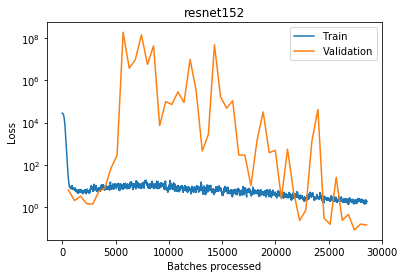

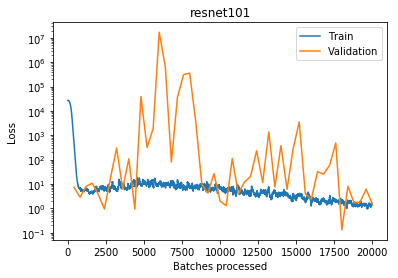

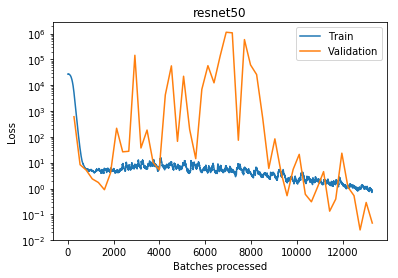

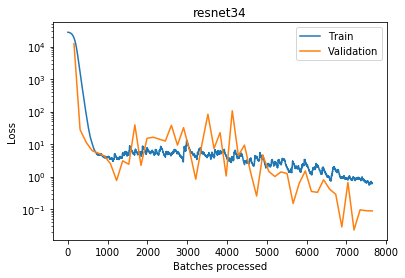

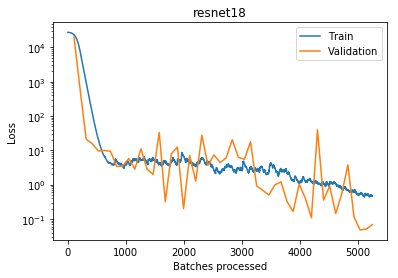

In [7]:
runs = []

for (epochs, architecture, bs) in [(50, models.resnet152, 70),(50, models.resnet101, 100), (50, models.resnet50, 150), (50, models.resnet34, 260), (50, models.resnet18, 380)]:
    runs += [(epochs, 4e-2, 384, bs, architecture,  str(architecture).split()[1])] 

losses = []

for (epochs, lr, size, bs, architecture,  label) in runs:
    print(f'Starting {label}.')
    data_bunch = ll.databunch(bs=bs)
    data_bunch = data_bunch.normalize(imagenet_stats)
    model = cnn_learner(data_bunch, architecture, ps=0, true_wd = False, bn_wd = False, callback_fns=[CSVLogger])
    model.fit_one_cycle(epochs, slice(lr), wd=0)
    model.recorder.plot_losses()
    plt.yscale('log')
    plt.title(label)
    losses += [(label, model.recorder.losses, model.recorder.val_losses)]
    model.save(label)

In [8]:
labels, train_losses, val_losses = [], [], []
for (label, train_loss, val_loss) in losses:
    labels += [label]
    train_losses += [train_loss[-1].item()]
    val_losses   += [val_loss[-1].item()]

results = pd.DataFrame()
results['label'] = np.array(labels, dtype=np.str)

results['train_loss'] = np.array(train_losses, dtype=np.float32)
results['val_loss'] = np.array(val_losses, dtype=np.float32)
results.sort_values(by='val_loss', inplace=True)
display(results)  

,label,train_loss,val_loss
2,resnet50,0.869572,0.045960
4,resnet18,0.466324,0.068751
3,resnet34,0.628427,0.087708
0,resnet152,1.851568,0.141394
1,resnet101,1.442162,1.521404


In [9]:
# from fastai.callbacks import CSVLogger
# data_bunch = ll.databunch(bs=12)
# data_bunch = data_bunch.normalize(imagenet_stats)
# model = cnn_learner(data_bunch, models.resnet18, ps=0, true_wd = False, bn_wd = False, callback_fns=[CSVLogger])
# help(model)
# help(model.csv_logger)
# model.fit_one_cycle(1, slice(3e-2), wd=0)
# !ls

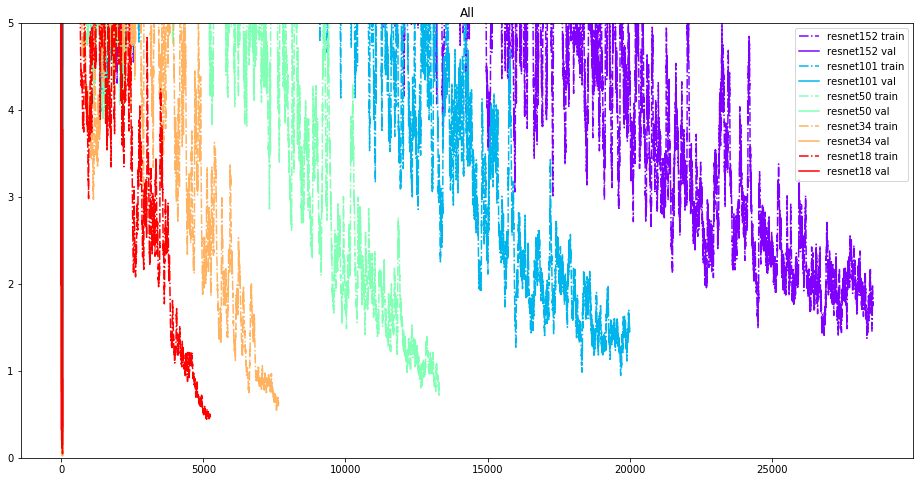

In [13]:
def plot_results(losses, title):
    colors = plt.cm.rainbow(np.linspace(0,1,len(runs)))
    plt.figure(figsize=(16,8))
    plt.ylim(0, 1000)
    for idx, (label, train_loss, val_loss) in enumerate(losses):
        color = colors[idx]
        plt.plot(train_loss, color=color, linestyle="-.", label=label+' train')
        plt.plot(val_loss,   color=color, linestyle="-", label=label+' val')
    plt.legend()
    plt.title(title)
    plt.ylim(0,5)
plot_results(losses, "All")
